In [23]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import segmentation_models_pytorch as smp
from torchviz import make_dot
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import plotly.graph_objects as go
from IPython.display import display, clear_output
import plotly.express as px
import math
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor, as_completed
import monai

%matplotlib inline

In [29]:
class newDataset(Dataset):
    def __init__(self, image_files, mask_files, patch_size=512, patch_overlap=0.2, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        self.patch_size = patch_size
        self.patch_overlap = patch_overlap
        self.patch_indices = self.calculate_patch_indices()

    def __len__(self):
        return len(self.patch_indices)

    def __getitem__(self, idx):
        img_path, mask_path, (y, x) = self.patch_indices[idx]
        patch_image, patch_mask = self.load_patch(img_path, mask_path, y, x)

        patch_image = self.image_histogram_equalization(patch_image.astype('float32') / patch_image.max())
        patch_mask = patch_mask.astype('float32') / 255.
        
        patch_image = torch.tensor(patch_image, dtype=torch.float32)
        patch_mask = torch.tensor(patch_mask, dtype=torch.float32)

        if self.transform:
            patch_image, patch_mask = self.augment_image(patch_image, patch_mask)

        return patch_image, patch_mask

    def calculate_patch_indices(self):
        with ThreadPoolExecutor() as executor:
            tasks = [executor.submit(self.calculate_patch_indices_for_image, img_path, mask_path)
                     for img_path, mask_path in zip(self.image_files, self.mask_files)]

            patch_indices = []
            for future in as_completed(tasks):
                patch_indices.extend(future.result())

        return patch_indices
    
    def calculate_patch_indices_for_image(self, img_path, mask_path):
        def calculate_dynamic_step(img_dim, patch_dim, overlap_fraction):
            overlap = int(patch_dim * overlap_fraction)
            step = patch_dim - overlap
            num_patches = math.ceil((img_dim - overlap) / step)
            step = (img_dim - patch_dim) / (num_patches - 1) if num_patches > 1 else 0
            return step, num_patches
        
        image = cv2.imread(img_path, 0)
        step_h, num_patches_h = calculate_dynamic_step(image.shape[0], self.patch_size, self.patch_overlap)
        step_w, num_patches_w = calculate_dynamic_step(image.shape[1], self.patch_size, self.patch_overlap)

        patch_indices = []
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                y = int(i * step_h)
                x = int(j * step_w)
                patch_indices.append((img_path, mask_path, (y, x)))
        
        return patch_indices


    def load_patch(self, img_path, mask_path, y, x):
        image = cv2.imread(img_path, 0)
        mask = cv2.imread(mask_path, 0)
        patch_img = image[y:y + self.patch_size, x:x + self.patch_size]
        patch_mask = mask[y:y + self.patch_size, x:x + self.patch_size]

        return patch_img, patch_mask
    
        
    """def reconstruct_image_from_patches(self, patches, original_shape):
        reconstructed_image = np.zeros(original_shape, dtype=patches[0][0].dtype)

        step = int(self.patch_size * (1 - self.patch_overlap))
        num_patches_h = math.ceil((original_shape[0] - self.patch_size) / step + 1)
        num_patches_w = math.ceil((original_shape[1] - self.patch_size) / step + 1)

        for i in range(num_patches_h):
            for j in range(num_patches_w):
                y = int(i * step)
                x = int(j * step)
                patch_img, _ = patches[i * num_patches_w + j] 
                reconstructed_image[y:y + self.patch_size, x:x + self.patch_size] = patch_img

        return reconstructed_image"""

    def image_histogram_equalization(self, image, number_bins=256):
        image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
        cdf = image_histogram.cumsum() 
        cdf = (number_bins-1) * cdf / cdf[-1] 
        
        image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    
        return image_equalized.reshape(image.shape)
    
    def augment_image(self, image, mask):
        shape = (*image.shape, 1 )
        image_np = image.reshape(shape).numpy()
        mask_np = mask.reshape(shape).numpy()
        augmented = self.transform(image = image_np,mask = mask_np)
        augmented_image , augmented_mask = augmented['image'],augmented['mask']
        augmented_image = augmented_image.reshape(augmented_image.shape[:-1])
        augmented_mask = augmented_mask.reshape(augmented_mask.shape[:-1])
        augmented_image = torch.tensor(augmented_image, dtype=torch.float32)
        augmented_mask  = torch.tensor(augmented_mask,dtype=torch.float32)
        
        return augmented_image,augmented_mask

    def calculate_num_patches(self, image_height, image_width):
        step_w = int(self.patch_size * (1-self.patch_overlap))
        step_h = int(self.patch_size * (1-self.patch_overlap))

        num_patches_w = math.ceil((image_width - self.patch_size) / step_w + 1)
        num_patches_h = math.ceil((image_height - self.patch_size) / step_h + 1)

        return num_patches_w * num_patches_h

    
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.epochs_no_improve = 0
        self.should_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.should_stop = True

In [25]:
base_path = "C:\\Users\\Bartek\\Desktop\\mgr\\train"
datasets = ["kidney_1_dense", "kidney_1_voi", "kidney_2", "kidney_3_sparse"]

image_files = []
labels_files = []
for dataset in datasets:
    images_path = os.path.join(base_path,dataset,"images")
    label_path = os.path.join(base_path,dataset,"labels")

    image_files.extend(sorted([os.path.join(images_path,f) for f in os.listdir(images_path) if f.endswith('.tif')]))
    labels_files.extend(sorted([os.path.join(label_path,f) for f in os.listdir(label_path) if f.endswith('.tif')]))

In [26]:
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    image_files, labels_files, test_size=0.15, random_state=42)

train_image_files[:10]

['C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\2249.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\1765.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_2\\images\\0339.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_2\\images\\0633.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_3_sparse\\images\\0070.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_2\\images\\1830.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0254.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_3_sparse\\images\\0052.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0221.tif',
 'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_2\\images\\0309.tif']

In [30]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.OneOf(
        [
            A.Blur(blur_limit=3, p=1),
            A.MotionBlur(blur_limit=3, p=1),
        ],
        p=0.7,
    )

])
train_dataset = newDataset(
    train_image_files, 
    train_mask_files,
    patch_size=512,
    patch_overlap=0.2, 
    transform=transform)

val_dataset = newDataset(val_image_files, 
                         val_mask_files)

In [20]:
train_dataset.patch_indices

[('C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0406.tif',
  'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\labels\\0406.tif',
  (0, 0)),
 ('C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0406.tif',
  'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\labels\\0406.tif',
  (0, 400)),
 ('C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0406.tif',
  'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\labels\\0406.tif',
  (395, 0)),
 ('C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0406.tif',
  'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\labels\\0406.tif',
  (395, 400)),
 ('C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0406.tif',
  'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\labels\\0406.tif',
  (791, 0)),
 ('C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\images\\0406.tif',
  'C:\\Users\\Bartek\\Desktop\\mgr\\train\\kidney_1_dense\\labels\\0406.tif',

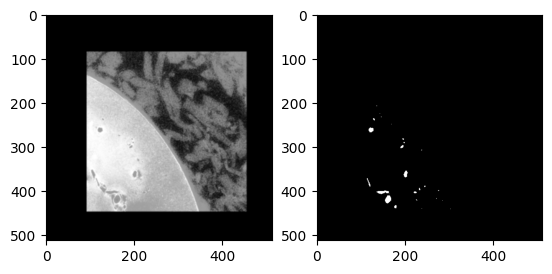

In [18]:
im, mask = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(im, cmap='grey')
plt.subplot(1,2,2)
plt.imshow(mask, cmap='grey')

In [132]:
def reconstruct_image_from_patches(patches, original_shape, patch_size, overlap_fraction):
    reconstructed_image = np.zeros(original_shape, dtype=patches[0].dtype)

    step = int(patch_size * (1 - overlap_fraction))
    num_patches_h = math.ceil((original_shape[0] - patch_size) / step + 1)
    num_patches_w = math.ceil((original_shape[1] - patch_size) / step + 1)

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            y = int(i * step)
            x = int(j * step)

            # Adjust the size of the patch if we are at the edges of the image
            patch_height = min(patch_size, original_shape[0] - y)
            patch_width = min(patch_size, original_shape[1] - x)

            patch_img = patches[i * num_patches_w + j]

            # Ensure the patch is the right size
            patch_img_adjusted = patch_img[:patch_height, :patch_width]

            reconstructed_image[y:y + patch_height, x:x + patch_width] = patch_img_adjusted

    return reconstructed_image

In [19]:
train_dataloader= DataLoader(train_dataset,batch_size=6,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=6,shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
model = smp.UnetPlusPlus(
    encoder_name='timm-resnest200e',
    encoder_weights='imagenet',
    decoder_attention_type="scse",
    in_channels=1
).to(device)

sum(p.numel() for p in model.parameters())

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest200-75117900.pth" to C:\Users\Bartek/.cache\torch\hub\checkpoints\resnest200-75117900.pth
100%|██████████| 269M/269M [00:33<00:00, 8.54MB/s] 


97362076

In [49]:
model = monai.networks.nets.SwinUNETR(
    img_size=(512,512), 
    in_channels=1, 
    out_channels=1, 
    use_checkpoint=True, 
    spatial_dims=2,
    depths=(10,8,8,6),
    num_heads=(6,12,24,48),
    feature_size=72,
    drop_rate=0.05,            
    attn_drop_rate=0.05
).to(device)

sum(p.numel() for p in model.parameters())


80573677

In [ ]:
model = torch.nn.DataParallel(model)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device

In [9]:
#dummy_input = torch.randn(1, 1, 928, 1312).to(device)  # Adjust the size as needed

#torch.onnx.export(model, dummy_input, "model.onnx", verbose=True)

In [10]:
#del dummy_input

In [11]:
torch.cuda.empty_cache()

In [13]:
fig = go.FigureWidget()
fig.add_scatter(name='Batch Training Loss')
fig.add_scatter(name='Epoch Training Loss')
fig.add_scatter(name='Epoch Validation Loss')

display(fig)

num_epochs = 500
early_stopping = EarlyStopping(patience=75, min_delta=0)
best_loss = float('inf')
all_train_losses = []
epoch_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []

    for batch_num, (images, masks) in enumerate(train_dataloader):
        b, h, w = images.shape
        images = images.reshape(b,1,h,w).to(device)
        masks = masks.reshape(b,1,h,w).to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss = loss.item()
        all_train_losses.append(train_loss)
        epoch_train_losses.append(train_loss)
        
        if batch_num % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_num+1}/{len(train_dataloader)}], Batch Loss: {train_loss:.8f}')

        fig.data[0].y = all_train_losses
        fig.data[0].x = list(range(len(all_train_losses)))

        

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    epoch_losses.append(avg_train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in val_dataloader:
            b, h, w = images.shape
            images = images.reshape(b,1,h,w).to(device)
            masks = masks.reshape(b,1,h,w).to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

        avg_val_loss = running_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)


    fig.data[1].y = epoch_losses
    fig.data[1].x = list(range(len(epoch_losses)))
    fig.data[2].y = val_losses
    fig.data[2].x = list(range(len(val_losses)))

    fig.write_html("train.html")

    if avg_val_loss < best_loss: 
        print(f"Validation Loss Improved ({best_loss} --> {avg_val_loss})")
        best_loss = avg_val_loss 

        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved as best_model.pth")

    early_stopping(avg_val_loss)
    if early_stopping.should_stop:
        print("Early stopping triggered")
        break

fig.write_html("train.html")
print(f'DONE')

FigureWidget({
    'data': [{'name': 'Batch Training Loss', 'type': 'scatter', 'uid': '371173c7-356e-4f43-aec2-a98cea90e458'},
             {'name': 'Epoch Training Loss', 'type': 'scatter', 'uid': 'e7b04663-3c18-4d65-a030-73f3223a7906'},
             {'name': 'Epoch Validation Loss', 'type': 'scatter', 'uid': '9d5fb0b0-ee93-47d3-b687-c852f16d1319'}],
    'layout': {'template': '...'}
})

Epoch [1/50], Batch [1/304], Batch Loss: 0.48063755
Epoch [1/50], Batch [2/304], Batch Loss: 0.45018038
Epoch [1/50], Batch [3/304], Batch Loss: 0.40781564
Epoch [1/50], Batch [4/304], Batch Loss: 0.36459312
Epoch [1/50], Batch [5/304], Batch Loss: 0.35052776
Epoch [1/50], Batch [6/304], Batch Loss: 0.29885811
Epoch [1/50], Batch [7/304], Batch Loss: 0.30266231
Epoch [1/50], Batch [8/304], Batch Loss: 0.26119241
Epoch [1/50], Batch [9/304], Batch Loss: 0.23827331
Epoch [1/50], Batch [10/304], Batch Loss: 0.22066724
Epoch [1/50], Batch [11/304], Batch Loss: 0.20187685
Epoch [1/50], Batch [12/304], Batch Loss: 0.18825209
Epoch [1/50], Batch [13/304], Batch Loss: 0.19040692
Epoch [1/50], Batch [14/304], Batch Loss: 0.16912006
Epoch [1/50], Batch [15/304], Batch Loss: 0.16048202
Epoch [1/50], Batch [16/304], Batch Loss: 0.13122162
Epoch [1/50], Batch [17/304], Batch Loss: 0.12616172
Epoch [1/50], Batch [18/304], Batch Loss: 0.11839454
Epoch [1/50], Batch [19/304], Batch Loss: 0.10916062
Ep

In [17]:
import re
import matplotlib.pyplot as plt
file = open('train.txt',mode='r')
train_logs = file.readlines()
train_logs

['Epoch [1/50], Batch [1/304], Batch Loss: 0.48063755\n',
 'Epoch [1/50], Batch [2/304], Batch Loss: 0.45018038\n',
 'Epoch [1/50], Batch [3/304], Batch Loss: 0.40781564\n',
 'Epoch [1/50], Batch [4/304], Batch Loss: 0.36459312\n',
 'Epoch [1/50], Batch [5/304], Batch Loss: 0.35052776\n',
 'Epoch [1/50], Batch [6/304], Batch Loss: 0.29885811\n',
 'Epoch [1/50], Batch [7/304], Batch Loss: 0.30266231\n',
 'Epoch [1/50], Batch [8/304], Batch Loss: 0.26119241\n',
 'Epoch [1/50], Batch [9/304], Batch Loss: 0.23827331\n',
 'Epoch [1/50], Batch [10/304], Batch Loss: 0.22066724\n',
 'Epoch [1/50], Batch [11/304], Batch Loss: 0.20187685\n',
 'Epoch [1/50], Batch [12/304], Batch Loss: 0.18825209\n',
 'Epoch [1/50], Batch [13/304], Batch Loss: 0.19040692\n',
 'Epoch [1/50], Batch [14/304], Batch Loss: 0.16912006\n',
 'Epoch [1/50], Batch [15/304], Batch Loss: 0.16048202\n',
 'Epoch [1/50], Batch [16/304], Batch Loss: 0.13122162\n',
 'Epoch [1/50], Batch [17/304], Batch Loss: 0.12616172\n',
 'Epoc

In [18]:
# Parsing the data for epoch-wise loss and validation loss
epoch_losses = {}
val_losses = {}

for line in train_logs:
    # Matching the pattern for epoch, batch, and batch loss
    epoch_match = re.search(r'Epoch \[(\d+)/\d+\]', line)
    val_loss_match = re.search(r'Validation Loss Improved \((?:inf|\d+\.\d+) --> (\d+\.\d+)\)', line)

    if epoch_match:
        epoch = int(epoch_match.group(1))
        if epoch not in epoch_losses:
            epoch_losses[epoch] = []

    loss_match = re.search(r'Batch Loss: (\d+\.\d+)', line)
    if loss_match:
        loss = float(loss_match.group(1))
        epoch_losses[epoch].append(loss)
    
    if val_loss_match:
        val_loss = float(val_loss_match.group(1))
        val_losses[epoch] = val_loss




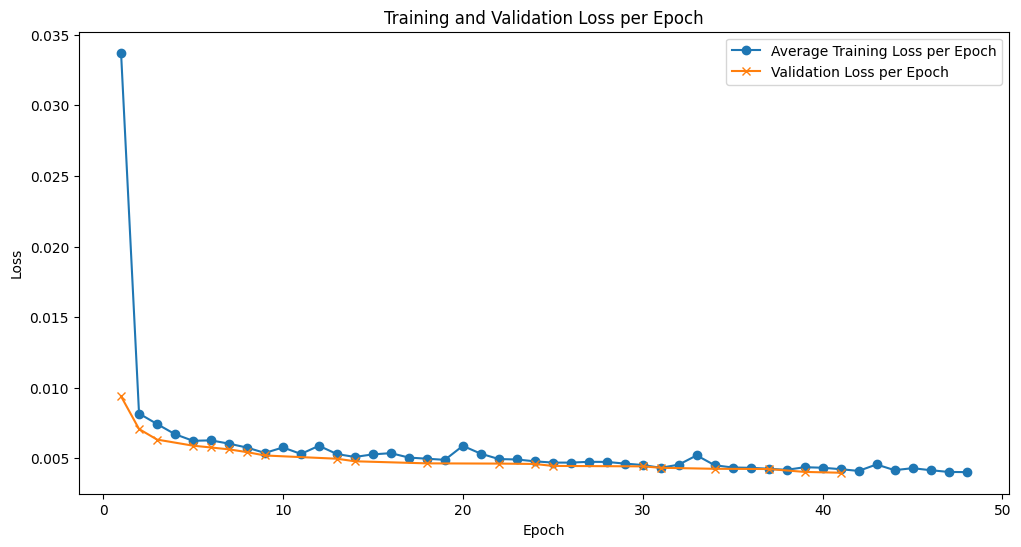

In [19]:
average_epoch_losses = {epoch: sum(losses)/len(losses) for epoch, losses in epoch_losses.items()}


plt.figure(figsize=(12, 6))

plt.plot(list(average_epoch_losses.keys()), list(average_epoch_losses.values()), label='Average Training Loss per Epoch', marker='o')
plt.plot(list(val_losses.keys()), list(val_losses.values()), label='Validation Loss per Epoch', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()